In [1]:
!pip install rdkit-pypi


import itertools
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt
from IPython.display import display
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import minimize
import random
import json
from rdkit.Chem import inchi

  Using cached rdkit_pypi-2022.9.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (29.4 MB)


# GNPS-JSON reader

In [2]:
# Load the JSON data
file_path = "GNPS-LIBRARY.json"
with open(file_path, 'r') as f:
    data = json.load(f)

compound_data = {}

def is_valid_smiles(smiles):
    """Check if a SMILES string is valid."""
    if not smiles or smiles.strip() in {"", "N/A"}:  # Catch empty, space-only, or "N/A"
        return False
    return Chem.MolFromSmiles(smiles) is not None

def inchi_to_smiles(inchi_str):
    """Convert InChI to SMILES if possible."""
    if not inchi_str or inchi_str.strip() in {"", "N/A"}:  # Check for empty values
        return None
    try:
        mol = inchi.MolFromInchi(inchi_str)
        return Chem.MolToSmiles(mol) if mol else None
    except:
        return None  # Avoid crashes if conversion fails

# Process each compound
for compound in data:
    compound_name = compound.get("Compound_Name", "Unknown")
    smiles = compound.get("Smiles") or compound.get("SMILES")
    inchi_str = compound.get("INCHI")

    # If SMILES is invalid, try generating it from InChI
    if not is_valid_smiles(smiles):
        smiles = inchi_to_smiles(inchi_str)

    if not is_valid_smiles(smiles):  # If still invalid, skip
        with open("missing_smiles.log", "a") as log_file:
            log_file.write(f"Skipping {compound_name}: Missing or invalid SMILES/InChI\n")
        continue

    # Extract metadata
    metadata = {key: compound.get(key) for key in [
        "spectrum_id", "source_file", "task", "scan", "ms_level",
        "library_membership", "Precursor_MZ", "ExactMass", "Charge",
        "Compound_Source", "Instrument", "Ion_Source", "Ion_Mode",
    ]}
    
    # Convert SMILES to InChI/InChIKey 
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        try:
            metadata.update({
                "smiles": smiles,
                "inchi": inchi.MolToInchi(mol),
                "inchikey": inchi.MolToInchiKey(mol)
            })
        except:
            metadata.update({"inchi": None, "inchikey": None})
    else:
        metadata.update({"inchi": None, "inchikey": None})

    # Parse peaks JSON 
    peaks_json = compound.get("peaks_json")
    try:
        spectra_df = pd.DataFrame(json.loads(peaks_json), columns=["m/z", "intensity"]) if isinstance(peaks_json, str) and peaks_json.strip().lower() != "n/a" else pd.DataFrame(columns=["m/z", "intensity"])
    except:
        spectra_df = pd.DataFrame(columns=["m/z", "intensity"])

    # Store the compound data
    compound_data[compound_name] = {"metadata": metadata, "spectra": spectra_df}

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Charges were rearranged

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Omitted undefined stereo

[07:53:58] WARNING: Proton(s) added/removed

[07:53:58] WARNING: Proton(s) added/

[07:54:03] WARNING: Omitted undefined stereo

[07:54:03] WARNING: Omitted undefined stereo

[07:54:03] WARNING: Omitted undefined stereo

[07:54:03] WARNING: Omitted undefined stereo

[07:54:03] WARNING: Omitted undefined stereo

[07:54:03] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 16
[07:54:03] Can't kekulize mol.  Unkekulized atoms: 10 11 12 14 16
[07:54:03] WARNING: Omitted undefined stereo

[07:54:03] WARNING: Omitted undefined stereo

[07:54:03] WARNING: Omitted undefined stereo

[07:54:03] WARNING: Omitted undefined stereo

[07:54:03] WARNING: Omitted undefined stereo

[07:54:03] WARNING: Omitted undefined stereo

[07:54:03] WARNING: Omitted undefined stereo

[07:54:03] WARNING: Omitted undefined stereo

[07:54:03] WARNING: Omitted undefined stereo

[07:54:03] WARNING: Omitted undefined stereo

[07:54:04] WARNING: Omitted undefined stereo

[07:54:04] WARNING: Omitted undefined stereo

[07:54:04] WARNING: Omitted undefined stereo

[07:54:04] WARNING: Omitted undefined st

[07:54:07] WARNING: Omitted undefined stereo

[07:54:07] WARNING: Omitted undefined stereo

[07:54:07] WARNING: Omitted undefined stereo

[07:54:07] WARNING: Omitted undefined stereo

[07:54:07] WARNING: Omitted undefined stereo

[07:54:07] WARNING: Omitted undefined stereo

[07:54:07] WARNING: Proton(s) added/removed

[07:54:07] WARNING: Omitted undefined stereo

[07:54:07] ERROR: 

[07:54:07] ERROR: 

[07:54:07] ERROR: 

[07:54:07] ERROR: 

[07:54:07] ERROR: 

[07:54:07] WARNING: Charges were rearranged

[07:54:07] WARNING: Omitted undefined stereo

[07:54:07] WARNING: Omitted undefined stereo

[07:54:07] WARNING: Omitted undefined stereo

[07:54:07] WARNING: Omitted undefined stereo

[07:54:07] WARNING: Omitted undefined stereo

[07:54:07] WARNING: Omitted undefined stereo

[07:54:08] WARNING: Omitted undefined stereo

[07:54:08] WARNING: Omitted undefined stereo

[07:54:08] WARNING: Omitted undefined stereo

[07:54:08] WARNING: Omitted undefined stereo

[07:54:08] WARNING: Omitted 

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Proton(s) added/removed

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefined stereo

[07:54:09] WARNING: Omitted undefin

[07:54:10] WARNING: Proton(s) added/removed; Omitted undefined stereo

[07:54:10] WARNING: Proton(s) added/removed; Omitted undefined stereo

[07:54:10] WARNING: Omitted undefined stereo

[07:54:10] WARNING: Proton(s) added/removed

[07:54:10] WARNING: Proton(s) added/removed

[07:54:10] WARNING: Proton(s) added/removed

[07:54:10] WARNING: Proton(s) added/removed

[07:54:10] WARNING: Proton(s) added/removed

[07:54:10] WARNING: Proton(s) added/removed

[07:54:10] WARNING: Proton(s) added/removed

[07:54:10] WARNING: Proton(s) added/removed

[07:54:10] WARNING: Proton(s) added/removed

[07:54:10] WARNING: Proton(s) added/removed

[07:54:10] WARNING: Proton(s) added/removed

[07:54:10] WARNING: Proton(s) added/removed

[07:54:10] WARNING: Proton(s) added/removed; Omitted undefined stereo

[07:54:10] WARNING: Proton(s) added/removed; Omitted undefined stereo

[07:54:10] WARNING: Proton(s) added/removed; Omitted undefined stereo

[07:54:10] WARNING: Proton(s) added/removed

[07:54:10] WAR

[07:54:11] WARNING: Omitted undefined stereo

[07:54:11] WARNING: Omitted undefined stereo

[07:54:11] WARNING: Omitted undefined stereo

[07:54:11] WARNING: Omitted undefined stereo

[07:54:11] WARNING: Omitted undefined stereo

[07:54:11] WARNING: Omitted undefined stereo

[07:54:11] WARNING: Omitted undefined stereo

[07:54:11] WARNING: Proton(s) added/removed; Omitted undefined stereo

[07:54:11] WARNING: Omitted undefined stereo

[07:54:11] WARNING: Omitted undefined stereo

[07:54:11] WARNING: Omitted undefined stereo

[07:54:11] WARNING: Omitted undefined stereo

[07:54:11] WARNING: Omitted undefined stereo

[07:54:11] WARNING: Omitted undefined stereo

[07:54:11] WARNING: Omitted undefined stereo

[07:54:12] WARNING: Omitted undefined stereo

[07:54:12] WARNING: Omitted undefined stereo

[07:54:12] WARNING: Omitted undefined stereo

[07:54:12] WARNING: Omitted undefined stereo

[07:54:12] WARNING: Omitted undefined stereo

[07:54:12] WARNING: Omitted undefined stereo

[07:54:12

[07:54:15] WARNING: Omitted undefined stereo

[07:54:15] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefined stereo

[07:54:16] WARNING: Omitted undefi

[07:54:17] WARNING: Omitted undefined stereo

[07:54:17] WARNING: Omitted undefined stereo

[07:54:17] WARNING: Omitted undefined stereo

[07:54:17] WARNING: Omitted undefined stereo

[07:54:17] WARNING: Omitted undefined stereo

[07:54:17] WARNING: Omitted undefined stereo

[07:54:17] WARNING: Omitted undefined stereo

[07:54:17] WARNING: Omitted undefined stereo

[07:54:17] WARNING: Omitted undefined stereo

[07:54:17] WARNING: Omitted undefined stereo

[07:54:17] WARNING: Omitted undefined stereo

[07:54:17] WARNING: Omitted undefined stereo

[07:54:17] WARNING: Omitted undefined stereo

[07:54:17] WARNING: Charges were rearranged

[07:54:17] WARNING: Charges were rearranged

[07:54:17] WARNING: Charges were rearranged

[07:54:17] WARNING: Charges were rearranged

[07:54:17] WARNING: Charges were rearranged

[07:54:17] WARNING: Charges were rearranged

[07:54:17] WARNING: Omitted undefined stereo

[07:54:17] WARNING: Omitted undefined stereo

[07:54:17] WARNING: Charges were rearran

[07:54:18] WARNING: Omitted undefined stereo

[07:54:18] WARNING: Omitted undefined stereo

[07:54:18] WARNING: Omitted undefined stereo

[07:54:18] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Charges were rearranged

[07:54:19] WARNING: Charges were rearranged

[07:54:19] WARNING: Charges were rearranged

[07:54:19] WARNING: Charges were rearranged

[07:54:19] WARNING: Charges were rearranged

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined s

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefined stereo

[07:54:19] WARNING: Omitted undefi

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefined stereo

[07:54:20] WARNING: Omitted undefi

[07:54:23] WARNING: Omitted undefined stereo

[07:54:23] WARNING: Omitted undefined stereo

[07:54:24] WARNING: Metal was disconnected; Proton(s) added/removed

[07:54:24] WARNING: Omitted undefined stereo

[07:54:24] WARNING: Omitted undefined stereo

[07:54:24] WARNING: Omitted undefined stereo

[07:54:24] WARNING: Omitted undefined stereo

[07:54:24] WARNING: Omitted undefined stereo

[07:54:24] WARNING: Omitted undefined stereo

[07:54:24] WARNING: Omitted undefined stereo

[07:54:24] WARNING: Omitted undefined stereo

[07:54:24] WARNING: Omitted undefined stereo

[07:54:24] WARNING: Omitted undefined stereo

[07:54:24] WARNING: Omitted undefined stereo

[07:54:24] WARNING: Omitted undefined stereo

[07:54:24] WARNING: Omitted undefined stereo

[07:54:24] WARNING: Omitted undefined stereo

[07:54:24] WARNING: Omitted undefined stereo

[07:54:24] WARNING: Omitted undefined stereo

[07:54:24] WARNING: Omitted undefined stereo

[07:54:24] WARNING: Omitted undefined stereo

[07:54:24] 

[07:54:37] WARNING: Proton(s) added/removed

[07:54:37] WARNING: Proton(s) added/removed

[07:54:37] WARNING: Omitted undefined stereo

[07:54:37] WARNING: Proton(s) added/removed

[07:54:37] WARNING: Charges were rearranged; Omitted undefined stereo

[07:54:37] WARNING: Omitted undefined stereo

[07:54:37] WARNING: Omitted undefined stereo

[07:54:37] WARNING: Omitted undefined stereo

[07:54:37] WARNING: Omitted undefined stereo

[07:54:37] WARNING: Omitted undefined stereo

[07:54:37] WARNING: Omitted undefined stereo

[07:54:37] WARNING: Omitted undefined stereo

[07:54:37] WARNING: Omitted undefined stereo

[07:54:37] WARNING: Omitted undefined stereo

[07:54:37] WARNING: Omitted undefined stereo

[07:54:37] WARNING: Proton(s) added/removed; Omitted undefined stereo

[07:54:37] WARNING: Omitted undefined stereo

[07:54:37] WARNING: Omitted undefined stereo

[07:54:37] WARNING: Omitted undefined stereo

[07:54:37] WARNING: Omitted undefined stereo

[07:54:37] WARNING: Omitted undef

[07:54:38] WARNING: Proton(s) added/removed; Omitted undefined stereo

[07:54:38] WARNING: Omitted undefined stereo

[07:54:38] WARNING: Omitted undefined stereo

[07:54:38] WARNING: Omitted undefined stereo

[07:54:38] WARNING: Omitted undefined stereo

[07:54:38] WARNING: Proton(s) added/removed

[07:54:38] WARNING: Omitted undefined stereo

[07:54:38] WARNING: Omitted undefined stereo

[07:54:38] WARNING: Omitted undefined stereo

[07:54:38] WARNING: Omitted undefined stereo

[07:54:38] WARNING: Omitted undefined stereo

[07:54:38] WARNING: Omitted undefined stereo

[07:54:38] WARNING: Proton(s) added/removed

[07:54:38] WARNING: Omitted undefined stereo

[07:54:38] WARNING: Omitted undefined stereo

[07:54:38] WARNING: Omitted undefined stereo

[07:54:38] WARNING: Omitted undefined stereo

[07:54:38] WARNING: Omitted undefined stereo

[07:54:38] WARNING: Omitted undefined stereo

[07:54:38] WARNING: Omitted undefined stereo

[07:54:38] WARNING: Omitted undefined stereo

[07:54:38] 

[07:54:39] WARNING: Proton(s) added/removed

[07:54:39] WARNING: Proton(s) added/removed

[07:54:39] WARNING: Metal was disconnected

[07:54:39] WARNING: Proton(s) added/removed

[07:54:39] WARNING: Proton(s) added/removed

[07:54:39] WARNING: Proton(s) added/removed

[07:54:39] WARNING: Metal was disconnected

[07:54:39] WARNING: Proton(s) added/removed

[07:54:39] WARNING: Omitted undefined stereo

[07:54:39] WARNING: Omitted undefined stereo

[07:54:39] WARNING: Omitted undefined stereo

[07:54:39] WARNING: Omitted undefined stereo

[07:54:39] WARNING: Proton(s) added/removed

[07:54:39] WARNING: Metal was disconnected

[07:54:39] WARNING: Proton(s) added/removed

[07:54:39] WARNING: Proton(s) added/removed

[07:54:39] WARNING: Proton(s) added/removed

[07:54:39] WARNING: Metal was disconnected; Proton(s) added/removed

[07:54:39] WARNING: Proton(s) added/removed

[07:54:39] WARNING: Proton(s) added/removed

[07:54:39] WARNING: Proton(s) added/removed

[07:54:39] WARNING: Proton(s) 

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefined stereo

[07:54:40] WARNING: Omitted undefi

[07:54:44] WARNING: Proton(s) added/removed; Omitted undefined stereo

[07:54:44] WARNING: Proton(s) added/removed; Omitted undefined stereo

[07:54:44] WARNING: Proton(s) added/removed; Omitted undefined stereo

[07:54:44] WARNING: Omitted undefined stereo

[07:54:44] WARNING: Omitted undefined stereo

[07:54:44] WARNING: Omitted undefined stereo

[07:54:44] WARNING: Omitted undefined stereo

[07:54:44] WARNING: Omitted undefined stereo

[07:54:44] WARNING: Omitted undefined stereo

[07:54:44] WARNING: Omitted undefined stereo

[07:54:44] WARNING: Omitted undefined stereo

[07:54:44] WARNING: Omitted undefined stereo

[07:54:44] WARNING: Omitted undefined stereo

[07:54:44] WARNING: Omitted undefined stereo

[07:54:44] WARNING: Omitted undefined stereo

[07:54:44] WARNING: Omitted undefined stereo

[07:54:44] WARNING: Omitted undefined stereo

[07:54:44] WARNING: Omitted undefined stereo

[07:54:44] WARNING: Omitted undefined stereo

[07:54:44] WARNING: Omitted undefined stereo

[07:5

# RANDOM 

In [ ]:
first_compound_name = random.choice(list(compound_data.keys()))  # Get a random key (compound name)
# first_compound_name = "Alanine"  

first_compound = compound_data[first_compound_name]  # Get its data
spectra_df = first_compound["spectra"]
smiles = first_compound["metadata"].get("smiles", None)

# Normalize intensity values
if not spectra_df.empty:
    max_intensity = spectra_df["intensity"].max()
    spectra_df["normalised_intensity"] = (spectra_df["intensity"] / max_intensity) * 100

# Print metadata
print("Compound Name:", first_compound_name)
print("Metadata:", first_compound["metadata"])
print("Stored spectra:", first_compound["spectra"], "\n")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# --- Plot Molecular Structure ---
if smiles:
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol, size=(300, 300))
    axes[0].imshow(img)
    axes[0].axis("off")
    axes[0].set_title("SMILES: CCCCN(C(=O)CCC)C(CC)C(=O)NC1CCCCC1")

# --- Plot Normalized Mass Spectrum ---
if not spectra_df.empty:
    axes[1].bar(spectra_df["m/z"], spectra_df["normalised_intensity"], width=1.0, color="black")
    axes[1].set_xlabel("m/z")
    axes[1].set_ylabel("Relative Intensity (%)")
    axes[1].set_title(f"Experimental Mass Spectrum of {first_compound_name}")
else:
    axes[1].text(0.5, 0.5, "No spectral data available", ha="center", va="center", fontsize=12)
    axes[1].axis("off")

plt.tight_layout()
plt.show()


In [201]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from rdkit import Chem
# from rdkit.Chem import Draw

# # Set the target GNPS ID (remove any extraneous brackets if necessary)
# target_gnps_id = "CCMSLIB00005884079"

# # Find the compound with the matching GNPS ID from the compound_data dictionary
# target_compound = None
# compound_name = None
# for name, data in compound_data.items():
#     if data["metadata"].get("spectrum_id") == target_gnps_id:
#         compound_name = name
#         target_compound = data
#         break

# if target_compound is None:
#     print(f"Compound with GNPS ID {target_gnps_id} not found in the database.")
# else:
#     spectra_df = target_compound["spectra"].copy()  # Copy to avoid SettingWithCopyWarning
#     smiles = target_compound["metadata"].get("smiles", None)

#     # Normalize intensity values if spectral data exists
#     if not spectra_df.empty:
#         max_intensity = spectra_df["intensity"].max()
#         if max_intensity > 0:
#             spectra_df["normalised_intensity"] = (spectra_df["intensity"] / max_intensity) * 100

#     # Print metadata
#     print("Compound Name:", compound_name)
#     print("Metadata:", target_compound["metadata"])
#     print("Stored spectra:", spectra_df, "\n")

#     # Create subplots for the molecular structure and the mass spectrum
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#     # --- Plot Molecular Structure ---
#     if smiles:
#         mol = Chem.MolFromSmiles(smiles)
#         img = Draw.MolToImage(mol, size=(300, 300))
#         axes[0].imshow(img)
#         axes[0].axis("off")
#         axes[0].set_title(f"SMILES: {smiles}")
#     else:
#         axes[0].text(0.5, 0.5, "No molecular structure available", ha="center", va="center", fontsize=12)
#         axes[0].axis("off")

#     # --- Plot Normalized Mass Spectrum with Annotations for Intensity > 10 ---
#     if not spectra_df.empty:
#         axes[1].bar(spectra_df["m/z"], spectra_df["normalised_intensity"], color="black")
#         axes[1].set_xlabel("m/z")
#         axes[1].set_ylabel("Relative Intensity (%)")
#         axes[1].set_title(f"Mass Spectrum of {compound_name}")

#         # Annotate peaks with normalized intensity greater than 10
#         for i, row in spectra_df.iterrows():
#             if row["normalised_intensity"] > 10:
#                 axes[1].annotate(
#                     f"{int(row['m/z'])}",
#                     (row["m/z"], row["normalised_intensity"] + 2),  # Position above the peak
#                     fontsize=8, ha="center", va="bottom", color="red"
#                 )
#     else:
#         axes[1].text(0.5, 0.5, "No spectral data available", ha="center", va="center", fontsize=12)
#         axes[1].axis("off")

#     plt.tight_layout()
#     plt.show()


# Molecule Filter

In [202]:
# import random
# import pandas as pd
# import matplotlib.pyplot as plt
# from rdkit import Chem
# from rdkit.Chem import Draw, Descriptors


# # Function to get molecular weight from SMILES
# def get_molecular_weight(smiles):
#     if smiles:
#         mol = Chem.MolFromSmiles(smiles)
#         return Descriptors.MolWt(mol) if mol else float("inf")
#     return float("inf")

# # Filter compounds with molecular weight < 100
# small_compounds = {
#     name: data for name, data in compound_data.items()
#     if data["metadata"].get("molecular_weight", get_molecular_weight(data["metadata"].get("smiles", ""))) < 150
# }

# if not small_compounds:
#     print("No compounds found with a molecular weight less than 10.")
# else:
#     # Randomly select a compound
#     first_compound_name = random.choice(list(small_compounds.keys()))
#     first_compound = small_compounds[first_compound_name]
#     spectra_df = first_compound["spectra"].copy()  # Ensure no SettingWithCopyWarning
#     smiles = first_compound["metadata"].get("smiles", None)

#     # Normalize intensity values if spectra exist
#     if not spectra_df.empty:
#         max_intensity = spectra_df["intensity"].max()
#         if max_intensity > 0:
#             spectra_df["normalised_intensity"] = (spectra_df["intensity"] / max_intensity) * 100

#     # Print metadata
#     print("Compound Name:", first_compound_name)
#     print("Metadata:", first_compound["metadata"])
#     print("Stored spectra:", spectra_df, "\n")

#     # Create subplots
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#     # --- Plot Molecular Structure ---
#     if smiles:
#         mol = Chem.MolFromSmiles(smiles)
#         img = Draw.MolToImage(mol, size=(300, 300))
#         axes[0].imshow(img)
#         axes[0].axis("off")
#         axes[0].set_title(f"SMILES: {smiles}")
#     else:
#         axes[0].text(0.5, 0.5, "No molecular structure available", ha="center", va="center", fontsize=12)
#         axes[0].axis("off")

#     # --- Plot Normalized Mass Spectrum with Annotations for Intensity > 10 ---
#     if not spectra_df.empty:
#         axes[1].bar(spectra_df["m/z"], spectra_df["normalised_intensity"], color="black")
#         axes[1].set_xlabel("m/z")
#         axes[1].set_ylabel("Relative Intensity (%)")
#         axes[1].set_title(f"Mass Spectrum of {first_compound_name}")

#         # Annotate only peaks where normalised intensity is > 10
#         for i, row in spectra_df.iterrows():
#             if row["normalised_intensity"] > 10:
#                 axes[1].annotate(
#                     f"{int(row['m/z'])}", 
#                     (row["m/z"], row["normalised_intensity"] + 2),  # Position above peak
#                     fontsize=8, ha="center", va="bottom", color="red"
#                 )
#     else:
#         axes[1].text(0.5, 0.5, "No spectral data available", ha="center", va="center", fontsize=12)
#         axes[1].axis("off")

#     plt.tight_layout()
#     plt.show()


In [203]:
molecule_smiles = smiles
molecule = Chem.MolFromSmiles(molecule_smiles)
initial_mass = CalcExactMolWt(molecule)

fragmentations = { 
#CMF Reactions:
##Positive ion mode:
    'simple_inductive_cleavage': '[O+,N+,S+:2]-[C:1]>>[C+:1].[O,N,S:2]',  # Simple inductive cleavage with charge migration
    'inductive_cleavage_heteroatom': '[O,N,S:1]-[C:2]-[*+:3]>>[O+,N+,S+:1]=[C+:2].[*:3]',  # Heteroatom-assisted cleavage
    'displacement_reaction_positive_a': '[O,N,S:1]-[C:2]-[C:3]-[*+:4]>>[C:3]1-[C:2]-[O+,N+,S+:1]-1.[*:4]',  # Displacement reaction in positive ion mode
    'displacement_reaction_positive_b': '[O,N,S,C:1]=[C:2]-[C:3]-[*+:4]>>[O+,N+,S+,C+:1]-[C:2]=[C:3].[*:4]',  # Displacement reaction in positive ion mod
    'beta_hydrogen_removal_positive': '[O,N,S:1]-[C:2]-[C;H:3]-[C:4]-[*+:5]>>[O+,N+,S+;H1:1]-[C:2]-[C:3]=[C:4].[*:5]',  # β-hydrogen removal with charge migration
    'grob_wharton_fragmentation': '[O,N,S:1]-[C:2]-[C:3]-[C:4]-[*+:5]>>[O+,N+,S+:1]=[C:2].[C:3]=[C:4].[*:5]',  # Grob-Wharton fragmentation

##Negative ion mode:
    'alpha_elimination': '[C:1]-[C:2](=[O,S,N:3])-[O-,N-,S-:4]>>[C-:1].[C:2](=[O,S,N:3])-[O,N,S:4]',  # α-Elimination
    'gamma_elimination': '[O-,N-,S-:1]-[C:2]=[C:3]-[C:4]-[*:5]>>[O,N,S:1]=[C:2]-[C:3]=[C:4].[*-:5]',  # γ-Elimination
    'epsilon_elimination': '[O-,N-,S-:1]-[C:2]=[C:3]-[C:4]=[C:5]-[C:6][*:7]>>[O,N,S:1]=[C:2]-[C:3]=[C:4]-[C:5]=[C:6].[*-:7]',  # ε-Elimination
    'displacement_reaction_negative': '[O-,N-,S-:1]-[C:2]-[C:3]-[*:4]>>[O,N,S:1]1-[C:2]-[C:3]-1.[*-:4]',  # Displacement reaction (negative mode)
    'beta_hydrogen_removal_negative': '[O-,N-,S-:1]-[C:2]-[C;H:3]-[C:4]-[*:5]>>[O,N,S;H1:1]-[C:2]-[C:3]=[C:4].[*-:5]',  # β-Hydrogen removal (negative mode)
    
#CRF Reactions:
    'remote_hydrogen_rearrangement_a': '[O,N,S:1]-[C:2]-[C:3]-[H:4]>>[C:2]=[C:3].[H:4]-[O,N,S:1]',  # Remote H rearrangement
    'remote_hydrogen_rearrangement_b': '[C:1]-[C:2]-[O:3]-[H:4]>>[C:1]-[H:4].[C:2]=[O:3]',  # Alternative remote H rearrangement
    'retro_diels_alder': '[C:1]1=[C:2]-[C:3]-[C:4]-[C:5]-[C:6]-1>>[C:6]=[C:1]-[C:2]=[C:3].[C:4]=[C:5]',  # Retro-Diels-Alder (RDA) reaction
    'retro_ene': '[C:2]=[C:1]-[C:3]-[C:4]-[C:5]-[H:6]>>[H:6]-[C:2]-[C:3]=[C:1].[C:4]=[C:5]',  # Retro-ene reaction
    'retro_heteroene': '[O,N,S:1]=[C:2]-[C:3]-[C:4]-[C:5]-[H:6]>>[H:6]-[O,N,S:1]-[C:2]=[C:3].[C:4]=[C:5]',  # Retro-heteroene reaction
    'charge_remote_fragmentation': '[H:1]-[C:2]-[C:3]-[C:4]-[C:5]-[H:6]>>[C:2]=[C:3].[C:4]=[C:5].[H:1]-[H:6]',  # Charge remote fragmentation
    'aromatic_elimination': '[C:1]-[C:2]-[C:3]-[C:4]-[C:5]-[C:6]-[C:7]-[C:8]-[O,N,S:9]>>[C:1]=[C:8]-[O,N,S:9].[c:2]1[c:3][c:4][c:5][c:6][c:7]1',  
    'pericyclic_shift': '[C:1]-[C:2]-[C:3]-[C:4]-[C:5]-[C:6]>>[C:1]=[C:2].[C:5]=[C:6].[C:3]=[C:4]', 
    'pericyclic_1_3_shift': '[H:1]-[C:2]-[C:3]=[C:4]-[C:5]=[C:6]>>[C:2]=[C:3]-[C:4](-[H:1])=[C:5]-[C:6]', 
    'pericyclic_1_5_shift': '[H:1]-[C:2]-[C:3]=[C:4]-[C:5]=[C:6]>>[C:2]=[C:3]-[C:4]=[C:5]-[C:6](-[H:1])', 
    'carbon_monoxide_elimination_a': '[C:1]1-[C:2]-[C:3]-[C:4]-[C:5]-[C:6](=O)-1>>[C:1]1-[C:2]-[C:3]-[C:4]-[C:5]-1.[C:6](#O)',  # CO elimination from cyclic carbonyls
    'carbon_monoxide_elimination_b': '[C:6](#[O+1])-[C:1]-[C:2]-[C:3]-[C:4]-[C-:5]>>[C:1]1-[C:2]-[C:3]-[C:4]-[C:5]-1.[C:6](#O)',  # Alternative CO elimination
    'radical_fragmentation': '[C:1]-[O,N,S:2]>>[C^1:1].[O^1,N^1,S^1:2]',  # Radical fragmentation
}

reactions = {name: AllChem.ReactionFromSmarts(smarts) for name, smarts in fragmentations.items()}
ionisation_rxn = AllChem.ReactionFromSmarts('[O,N,S:2]>>[H][O+,N+,S+:2]')
product_sets = ionisation_rxn.RunReactants((molecule,))

if not product_sets:
    raise ValueError("Ionisation failed, no products generated.")
    
ionised_product = product_sets[0][0]
Chem.SanitizeMol(ionised_product)
ionised_mass = CalcExactMolWt(ionised_product)
peaks_df = pd.DataFrame({'mz': [ionised_mass], 'intensity': ["1"]})
print(f"length of products_sets (ionsied products formed) : ", len(product_sets))









edges = []
fragmentation_tree = []
processed_fragments = set()
######
fragment_images = []
######

for ionised_product_tuple in product_sets:  
    for ionised_product in ionised_product_tuple:  
        Chem.SanitizeMol(ionised_product)  
        ionised_mass = CalcExactMolWt(ionised_product)  

        # Add ionized product mass to peaks_df if not already present
        if not any(abs(ionised_mass - mz) < 0.5 for mz in peaks_df['mz']):  
            peaks_df = pd.concat([peaks_df, pd.DataFrame({'mz': [ionised_mass], 'intensity': ["1"]})], ignore_index=True)  

        # Initialize fragmentation process  
        new_fragments = [(ionised_product, ionised_mass)]  

        while new_fragments:  
            current_fragments = new_fragments  
            new_fragments = []  

            for parent, parent_mass in current_fragments:  
                parent_key = Chem.MolToSmiles(parent)  # Use SMILES instead of InChIKey to allow more variations  
                if parent_key in processed_fragments:  
                    continue  
                processed_fragments.add(parent_key)  

                for loss_name, reaction in reactions.items():  
                    try:  
                        product_sets = reaction.RunReactants((parent,))  


                        if product_sets:  
                            for product_tuple in product_sets:  # Process ALL products, not just the first  
                                for fragment in product_tuple:  
                                    try:  
                                        Chem.SanitizeMol(fragment)  
                                    except Exception as e:  
                                        continue  

                                    fragment_mass = CalcExactMolWt(fragment)  

                                    # Allow multiple fragments and prevent duplicates  
                                    if not any(abs(fragment_mass - mz) < 0.5 for mz in peaks_df['mz']):  
                                        peaks_df = pd.concat(  
                                            [peaks_df, pd.DataFrame({'mz': [fragment_mass], 'intensity': ["1"]})],  
                                            ignore_index=True,  
                                        )  
                                        new_fragments.append((fragment, fragment_mass))  
                                        edges.append((parent_mass, fragment_mass))  
                                        fragmentation_tree.append((parent_mass, fragment_mass, loss_name))  

                                        ############### Generate and store images for visualization  
                                        parent_img = Draw.MolToImage(parent)  
                                        fragment_img = Draw.MolToImage(fragment)  
                                        fragment_images.append((parent_img, fragment_img, parent_mass, fragment_mass, loss_name))  
                                        ###############
                    except Exception as e:  
                        print(f"Reaction {loss_name} failed on {Chem.MolToSmiles(parent)}: {e}")  
                        continue  

print(edges)  
print(peaks_df)  

# ###########
# # Display the parent and corresponding fragment pairs side by side
# fig, axes = plt.subplots(len(fragment_images), 2, figsize=(6, 3 * len(fragment_images)))

# for i, (parent_img, fragment_img, parent_mass, fragment_mass, loss_name) in enumerate(fragment_images):
#     # Parent molecule
#     axes[i, 0].imshow(parent_img)
#     axes[i, 0].set_title(f"Parent (m/z={parent_mass:.2f})")
#     axes[i, 0].axis("off")

#     # Fragment molecule
#     axes[i, 1].imshow(fragment_img)
#     axes[i, 1].set_title(f"Fragment (m/z={fragment_mass:.2f})\n\n{loss_name.replace('_', ' ')}")
#     axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

length of products_sets (ionsied products formed) :  16


[08:43:39] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:39] Can't kekulize mol.  Unkekulized atoms: 5
[08:43:39] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:39] Can't kekulize mol.  Unkekulized atoms: 3 5
[08:43:39] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3
[08:43:39] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:39] Can't kekulize mol.  Unkekulized atoms: 1 3
[08:43:39] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:39] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:39] Can't kekulize mol.  Unkekulized atoms: 1
[08:43:39] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:39] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:39] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:39] Can't kekulize mol.  Unkekulized atoms: 0 3
[08:43:39] Explicit valence for ato

[08:43:40] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:40] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:40] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:40] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:40] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:40] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:40] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:40] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:40] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:40] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:40] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:40] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:40] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:40] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:40]

[08:43:41] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:41] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:41] Can't kekulize mol.  Unkekulized atoms: 0 2
[08:43:41] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:41] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:41] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:41] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:41] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:41] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:41] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:41] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:41] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:41] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:41] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:41] Can't kekulize mol.  Unkekulized atoms: 1

[08:43:42] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:42] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:42] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:42] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:42] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:42] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:43] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:43] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:43] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:43] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:43] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:43] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:43] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:43] Explicit valence for atom # 1 C, 5, is g

[08:43:43] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:43] Can't kekulize mol.  Unkekulized atoms: 1
[08:43:43] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:43] Can't kekulize mol.  Unkekulized atoms: 0 3
[08:43:43] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:43] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:43] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:43] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:43] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:43] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:43] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:43] Can't kekulize mol.  Unkekulized atoms: 2 5
[08:43:43] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:43] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[08:43:43] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:4

[08:43:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 1 C, 5, is g

[08:43:44] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:44] Explicit valence for atom # 1 C, 5, is g

[08:43:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:45] Can't kekulize mol.  Unkekulized atoms: 1
[08:43:45] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:45] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:45] Can't kekulize mol.  Unkekulized atoms: 5
[08:43:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom #

[08:43:45] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:45] Explicit valence for atom # 0 C, 5, is g

[08:43:46] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 1 C, 5, is g

[08:43:46] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Can't kekulize mol.  Unkekulized atoms: 2 5
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Can't kekulize mol.  Unkekulized atoms: 2 4
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Can't kekulize mol.  Unkekulized atoms: 3 5
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Can't kekulize mol.  Unkekulized atoms: 1 3
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Can't kekulize mol.  Unkekulized atoms: 0 3
[08:43:46] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:46] Can't kekulize mol.  Unkekulized atoms: 2 4
[08:43:46] Explicit valence for a

[08:43:46] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:46] Can't kekulize mol.  Unkekulized atoms: 0 3 4
[08:43:46] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Can't kekulize mol.  Unkekulized atoms: 0 1 3
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Can't kekulize mol.  Unkekulized atoms: 2 5
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Can't kekulize mol.  Unkekulized atoms: 2 4
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than

[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:46] Explicit valence for atom # 1 C, 5, is g

[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3
[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Can't kekulize mol.  Unkekulized atoms: 1 3
[08:43:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:47] Can't kekulize mol.  Unkekulized atoms: 1
[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Can't kekulize mol.  Unkekulized atoms: 0 3
[08:43:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:47] Can't kekulize mol.  Unkekulized atoms: 3 5
[08:43:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Can't kekulize mol.  Unkekulized atoms: 2 4
[08:43:47] Explicit valence f

[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Can't kekulize mol.  Unkekulized atoms: 3 5
[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3
[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Can't kekulize mol.  Unkekulized atoms: 1 3
[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Can't kekulize mol.  Unkekulized atoms: 5
[08:43:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:47] Can't kekulize mol.  Unkekulized atoms:

[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:47] Can't kekulize mol.  Unkekulized atoms: 1
[08:43:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:47] Can't kekulize mol.  Unkekulized atoms: 1 3
[08:43:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:47] Can't kekulize mol.  Unkekulized atoms: 0 2 4
[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Can't kekulize mol.  Unkekulized atoms: 5
[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Can't kekulize mol.  Unkekulized atoms: 3 5
[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Explic

[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:47] Explicit valence for atom # 1 C, 5, is g

[08:43:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 1 C, 5, is g

[08:43:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:48] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:48] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:48] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[08:43:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:48] Can't kekulize mol.  Unkekulized atoms: 0 3 4
[08:43:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:48] Can't kekulize mol.  Unkekulized atoms: 0 1 3
[08:43:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 1 C, 5, is grea

[08:43:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:48] Can't kekulize mol.  Unkekulized atoms: 0 2
[08:43:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:48] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:48] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:48] Explicit valence for 

[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Can't kekulize mol.  Unkekulized atoms: 0 3 4
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Can't kekulize mol.  Unkekulized atoms: 0 1 3
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Can't kekulize mol.  Unkekulized atoms: 0 3 4
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than per

[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[08:43:49] Can't kekulize mol.  Unkekulized atoms: 4
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Can't kekulize mol.  Unkekulized atoms: 0 3 4
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Can't kekulize mol.  Unkekulized atoms: 0 1 3
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[

[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Can't kekulize mol.  Unkekulized atoms: 0 3 4
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Can't kekulize mol.  Unkekulized atoms: 0 2 4
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Can't kekulize mol.  Unkekulized atoms: 0 4
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Can't kekulize mol.  Unkekulized atoms: 0 1 3
[08:43:49] Explicit valence for atom # 0 C, 5, is greate

[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is g

[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:49] Explicit valence for atom # 0 C, 5, is g

[08:43:50] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:50] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:50] Can't kekulize mol.  Unkekulized atoms: 0 2
[08:43:50] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:50] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:50] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:50] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:50] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:50] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:50] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:50] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:50] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:50] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:50] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:50] Explicit valence for 

[08:43:50] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:50] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:50] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:50] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:50] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:50] Can't kekulize mol.  Unkekulized atoms: 1
[08:43:50] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:50] Can't kekulize mol.  Unkekulized atoms: 5
[08:43:50] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:50] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:50] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:50] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:50] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:50] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:50] Explicit valence for atom #

[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 1 C, 5, is g

[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Can't kekulize mol.  Unkekulized atoms: 1
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Can't kekulize mol.  Unkekulized atoms: 0 2
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Can't kekulize mol.  Unkekulized atoms: 5
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08

[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Can't kekulize mol.  Unkekulized atoms: 1
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Can't kekulize mol.  Unkekulized atoms: 5
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom #

[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Can't kekulize mol.  Unkekulized atoms: 0 2
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Explicit valence for 

[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Can't kekulize mol.  Unkekulized atoms: 2 4
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Can't kekulize mol.  Unkekulized atoms: 3 5
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Can't kekulize mol.  Unkekulized atoms: 1 3
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Can't kekulize mol.  Unkekulized atoms: 2 4
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:51] Can't kekulize mol.  Unkekulized atoms: 1
[08:43:51] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:51] Can't 

[08:43:52] Can't kekulize mol.  Unkekulized atoms: 3 5
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permit

[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is g

[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Can't kekulize mol.  Unkekulized atoms: 1 3
[08:43:52] E

[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is g

[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:52] Can't kekulize mol.  Unkekulized atoms: 

[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Can't kekulize mol.  Unkekulized atoms: 1 2 3
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Can't kekulize mol.  Unkekulized atoms: 1 3
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Can't kekulize mol.  Unkekulized atoms: 1
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Can't kekulize mol.  Unkekulized atoms: 0 3
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Can't kekulize mol.  Unkekulized atoms: 2 4
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] 

[08:43:53] Can't kekulize mol.  Unkekulized atoms: 1
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Can't kekulize mol.  Unkekulized atoms: 0 1 3
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Can't kekulize mol.  Unkekulized atoms: 0 3 4
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence fo

[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is g

[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:53] Explicit valence for atom # 1 C, 5, is g

[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Can't kekulize mol.  Unkekulized atoms: 0 2
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for 

[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is g

[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is g

[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Can't kekulize mol.  Unkekulized atoms: 0 4
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Can't kekulize mol.  Unkekulized atoms: 0 3 4
[08:43:54] Explicit valence for atom # 0 C, 5, is greate

[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Can't kekulize mol.  Unkekulized atoms: 0 3 4
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Can't kekulize mol.  Unkekulized atoms: 0 1 3
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:54] Can't kekulize mol.  Unkeku

[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 0 2
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Expli

[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 0 3 4
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 0 2
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 0 3 4
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted

[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 0 3 4
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 0 2
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5

[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 0 2
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Explicit valence for 

[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 2 4
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 0 3 5
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 1 3
[08:43:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 2 4
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Can't kekulize mol.  Unkekulized atoms: 1 4
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:55] Ca

[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 0 2 3
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 0 1 3
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 2 5
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 2 4
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 3 5
[08:43:

[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 0 C, 5, is g

[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 1 C, 5, is g

[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 2 4 5
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 1 3 4
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 0 1 5
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 2 4 5
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 1
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 0 4
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 0 1 3
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Can't kekuli

[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 0 3
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 0 1 4
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 2
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3
[08:43:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:56] Can't kekuli

[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Can't kekulize mol.  Unkekulized atoms: 1 3
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Can't kekulize mol.  Unkekulized atoms: 0 3 5
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Can't kekulize mol.  Unkekulized atoms: 2
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Can't kekulize mol.  Unkekulized atoms: 1
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permi

[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is g

[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is g

[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:57] Explicit valence for atom # 1 C, 5, is g

[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is g

[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is g

[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Can't kekulize mol.  Unkekulized atoms: 0 3 4
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Can't kekulize mol.  Unkekulized atoms: 0 1 3
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is grea

[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Can't kekulize mol.  Unkekulized atoms: 0 3 4
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Can't kekulize mol.  Unkekulized atoms: 0 1 3
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is grea

[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:58] Explicit valence for atom # 1 C, 5, is g

[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is g

[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is g

[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than perm

[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Can't kekulize mol.  Unkekulized atoms: 1
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Can't kekulize mol.  Unkekulized atoms: 0 2
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Can't kekulize mol.  Unkekulized atoms: 0
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Can't kekulize mol.  Unkekulized atoms: 5
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08

[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:43:59] Explicit valence for atom # 1 C, 5, is g

[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is g

[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Can't kekulize mol.  Unkekulized atoms: 0 1 3
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than perm

[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Can't kekulize mol.  Unkekulized atoms: 0 4
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Can't kekulize mol.  Unkekulized atoms: 0 1 5
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Can't kekulize mol.  Unkekulized atoms: 0 4 5
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence 

[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is g

[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:00] Explicit valence for atom # 0 C, 5, is g

[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Can't kekulize mol.  Unkekulized atoms: 0 1 3
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than perm

[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is g

[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Can't kekulize mol.  Unkekulized atoms: 2 5
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Can't kekulize mol.  Unkekulized atoms: 3 5
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Can't kekulize mol.  Unkekulized atoms: 2 4
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Can't kekulize mol.  Unkekulized atoms: 1 3
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01

[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:01] Explicit valence for atom # 0 C, 5, is g

[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 0 C, 5, is g

[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Can't kekulize mol.  Unkekulized atoms: 0 3 5
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Can't kekulize mol.  Unkekulized atoms: 1 3
[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Can't kekulize mol.  Unkekulized atoms: 0 2 5
[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Can't kekulize mol.  Unkekulized atoms: 1
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Can't kekulize mol.  Unkekulized atoms: 0 3
[08:44:02] Can't kekulize mol.  Unkekulized atoms: 1 2 4
[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Can't kekulize

[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Can't kekulize mol.  Unkekulized atoms: 

[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Can't kekulize mol.  Unkekulized atoms: 0 1 3
[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Can't kekulize mol.  Unkekulized atoms: 0 2 4 5
[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Can't kekulize mol.  Unkekulized atoms: 1
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Can't kekulize mol.  Unkekulized atoms: 0 3
[08:44:02] Explicit valence for atom # 1 C, 5, is greater than permitted
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[08:44:02] Explicit valence for atom # 0 C, 5, is greater than permitted
[08:44:02] Can't kekulize mol.  Unkekulized atoms: 2 4 5
[08:4

KeyboardInterrupt: 

In [ ]:
mz_values = peaks_df["mz"].values
intensities = peaks_df["intensity"].astype(float).values  # Convert to float if not already.

# Create the figure with a larger size.
plt.figure(figsize=(12, 8))

# Draw vertical lines for each m/z peak.
plt.vlines(mz_values, ymin=0, ymax=intensities, color='blue', linewidth=1.5, label="Preoptimised Intensities")

# Annotate each peak with its m/z value in black, rotated and offset to reduce overlap.
for x, y in zip(mz_values, intensities):
    plt.text(
        x,
        y + 0.02 * max(intensities),  # small vertical offset relative to max intensity
        f'{x:.2f}',                  # format to two decimal places
        ha='center',
        va='bottom',
        rotation=45,                 # rotate text 45 degrees
        fontsize=10,
        color='black'
    )

# Add axis labels and title.
plt.xlabel("m/z", fontsize=14)
plt.ylabel("Intensity", fontsize=14)
plt.title("Pre-optimised Simulated Mass Spectrum", fontsize=16, y=1.05)

# Customize tick labels for readability.
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Enable grid lines for better visual reference.
plt.grid(True, linestyle='--', alpha=0.6)

# Optionally adjust the legend location if needed to avoid overlap, e.g. upper-left corner.
# plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1, 0.95))  # or 'upper right', etc.

# Auto-adjust layout to prevent overlapping text.
plt.tight_layout()

# Display the plot.
plt.show()


# Genetic algorithm

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import KDTree

# --- Alternative Matching: For Each Simulated Peak, Find Closest Experimental Peak ---

# Extract experimental m/z values and intensities from spectra_df
experimental_mz = spectra_df["m/z"].values
experimental_intensities = spectra_df["normalised_intensity"].values

# Relax the experimental peak filter; use all peaks or a very low threshold
# Here we use > 0, so that even low-intensity peaks are considered
valid_indices = experimental_intensities > 0
filtered_mz = experimental_mz[valid_indices]
filtered_intensities = experimental_intensities[valid_indices]

# Build a KDTree from the experimental peaks
exp_tree = KDTree(filtered_mz.reshape(-1, 1))

# Tolerance for matching (adjust if needed; here we keep 2 m/z units)
tolerance_kdtree = 1

# For each simulated peak, query the KDTree for experimental peaks within tolerance
matched_peaks = {}
for sim_peak in peaks_df["mz"].values:
    indices = exp_tree.query_ball_point([sim_peak], r=tolerance_kdtree)
    if indices:  # If any experimental peaks are found within tolerance
        # Find the closest experimental peak (by absolute m/z difference)
        differences = [abs(filtered_mz[idx] - sim_peak) for idx in indices]
        best_idx = indices[np.argmin(differences)]
        matched_peaks[sim_peak] = filtered_intensities[best_idx]
    else:
        # If no match is found, assign a default value (e.g., 0)
        matched_peaks[sim_peak] = 0

# Map matched intensities to peaks_df
peaks_df["observed_intensity"] = peaks_df["mz"].map(matched_peaks)

print("Matched peaks:", matched_peaks)




# ------------------------------------------------------------------
# (The rest of your GA and optimization code remains unchanged below)

population_size = 50  # Number of individuals in each generation
generations = 1000    # Number of generations to evolve
mutation_rate = 0.1   # Probability of mutating a transition probability
tolerance = 0.05      # Error tolerance for intensity difference


def fitness_function(transition_probs, edges, peaks_df, tolerance=0.05):
    """
    Compare predicted intensities to observed intensities and optimize transition probabilities.
    """
    # Ensure mz values are rounded consistently
    peaks_df['mz'] = peaks_df['mz'].round(6)
    edges = [(round(i, 6), round(j, 6)) for i, j in edges]

    # Create a directed graph of the fragmentation tree
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # Perform topological sorting (process precursors before fragments)
    topo_order = list(nx.topological_sort(G))

    # Initialize calculated intensities using actual mz values as keys
    calculated_intensities = {mz: 0 for mz in peaks_df['mz'].values}

    # Ensure precursor node is in calculated_intensities
    precursor_node = topo_order[0]
    if precursor_node not in calculated_intensities:
        print(f"Error: Precursor node {precursor_node} not in peaks_df['mz']")
        return -float('inf')

    calculated_intensities[precursor_node] = 1  # Set precursor intensity to 1

    # Normalize transition probabilities
    for node in topo_order:
        outgoing_edges = [(i, j) for (i, j) in edges if i == node]
        total_prob = sum(transition_probs.get((node, j), 0) for _, j in outgoing_edges)
        if total_prob > 1:
            for _, j in outgoing_edges:
                transition_probs[(node, j)] /= total_prob

    # Propagate intensities through the fragmentation tree
    for node in topo_order:
        outgoing_edges = [(i, j) for (i, j) in edges if i == node]
        total_prob = sum(transition_probs.get((node, j), 0) for _, j in outgoing_edges)
        totalTransition_intensityChange = calculated_intensities.get(node, 0) * total_prob

        for (i, j) in edges:
            if i == node:
                if j not in calculated_intensities:
                    calculated_intensities[j] = 0  # Initialize missing nodes
                transition_intensity = calculated_intensities[i] * transition_probs.get((i, j), 0)
                calculated_intensities[j] += transition_intensity

        calculated_intensities[node] -= totalTransition_intensityChange

    # Compare calculated intensities with observed experimental intensities
    score = 0
    for mz in peaks_df['mz']:
        observed_intensity = peaks_df.loc[peaks_df['mz'] == mz, 'observed_intensity'].values[0]
        calculated_intensity = calculated_intensities.get(mz, 0)

        if observed_intensity > 0:
            error = abs(calculated_intensity - observed_intensity) / observed_intensity
        else:
            error = 0 if calculated_intensity == 0 else 1

        if error <= tolerance:
            score += 1 - error  # Reward small errors
        else:
            score -= error      # Penalize larger errors

    return score

def select_parents(population, fitness_scores):
    """
    Select parents using a roulette-wheel selection based on fitness scores.
    """
    min_fitness = min(fitness_scores)
    if min_fitness < 0:
        fitness_scores = [score - min_fitness + 1 for score in fitness_scores]

    total_fitness = sum(fitness_scores)
    selection_probs = [score / total_fitness if total_fitness != 0 else 1/len(fitness_scores) for score in fitness_scores]
    
    return np.random.choice(population, size=2, p=selection_probs, replace=False)

def initialize_population(edges):
    """
    Initialize a population of random transition probabilities for each edge.
    """
    population = []
    for _ in range(population_size):
        individual = {edge: random.uniform(0, 1) for edge in edges}
        population.append(individual)
    return population

def crossover(parent1, parent2):
    """
    Perform crossover between two parents to create an offspring.
    """
    return {key: parent1[key] if random.random() < 0.5 else parent2[key] for key in parent1}

def mutate(individual):
    """
    Perform mutation on an individual by randomly adjusting transition probabilities.
    """
    for key in individual:
        if random.random() < mutation_rate:
            individual[key] += random.uniform(-0.1, 0.1)
            individual[key] = max(0, min(1, individual[key]))  # Ensure probabilities remain between 0 and 1
    return individual

def genetic_algorithm(edges, peaks_df, patience=20, epsilon=1e-6):
    """
    Run the Genetic Algorithm to optimize transition probabilities for the fragmentation tree.
    """
    # Initialize population
    population = initialize_population(edges)
    
    best_fitness = float('-inf')
    no_improvement_count = 0

    for generation in range(generations):
        fitness_scores = [fitness_function(individual, edges, peaks_df) for individual in population]

        current_best_fitness = max(fitness_scores)
        
        if current_best_fitness > best_fitness + epsilon:
            best_fitness = current_best_fitness
            no_improvement_count = 0
        else:
            no_improvement_count += 1
        
        if no_improvement_count >= patience:
            print(f"Early stopping after {generation} generations with best fitness: {best_fitness}")
            break

        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = select_parents(population, fitness_scores)
            offspring1, offspring2 = mutate(crossover(parent1, parent2)), mutate(crossover(parent1, parent2))
            new_population.extend([offspring1, offspring2])
        
        population = new_population
    
    best_individual = max(population, key=lambda ind: fitness_function(ind, edges, peaks_df))
    return best_individual

# Call the GA to calculate transition probabilities
transition_probabilities = genetic_algorithm(edges, peaks_df)

# Print the final optimized transition probabilities
print(f"Optimized transition probabilities: {transition_probabilities}")

# Calculate and print the final fitness score for the optimized transition probabilities
final_fitness_score = fitness_function(transition_probabilities, edges, peaks_df)
print("Final fitness score:", final_fitness_score)

Matched peaks: {157.02438306009: 91.13420777037963, 139.01381837609: 0.07247064999746225, 19.01784113609: 0, 140.022191988: 0.16881536215891582, 141.02946844009: 0, 18.010564684: 0}
Early stopping after 20 generations with best fitness: 0.010972828145053626
Optimized transition probabilities: {(157.02438306009, 139.01381837609): 0.6403217843319634, (157.02438306009, 19.01784113609): 0.5487420141396298, (157.02438306009, 140.022191988): 0.5536070333380204, (157.02438306009, 141.02946844009): 0, (157.02438306009, 18.010564684): 0.6285347397778812}
Final fitness score: 0.010972828145053626


# old GA

In [189]:
# # # Extract m/z values and intensities from the JSON data
# # experimental_mz = spectra_df["m/z"].values
# # experimental_intensities = spectra_df["normalised_intensity"].values

# # # Filter out experimental peaks with intensity <= 10
# # valid_indices = experimental_intensities > 1
# # filtered_mz = experimental_mz[valid_indices]
# # filtered_intensities = experimental_intensities[valid_indices]


# # --- Match Experimental Peaks to Simulated Peaks ---
# def find_closest_peak(mz, experimental_mz, tolerance=2):
#     """Finds the closest simulated m/z peak within a given tolerance."""
#     differences = np.abs(simulated_mz - mz)
#     closest_idx = np.argmin(differences)
#     if differences[closest_idx] <= tolerance:
#         return simulated_mz[closest_idx]
#     return None

# # Extract m/z values and intensities from the JSON data
# experimental_mz = spectra_df["m/z"].values
# experimental_intensities = spectra_df["normalised_intensity"].values

# # Filter out experimental peaks with intensity <= 10
# valid_indices = experimental_intensities > 0.1
# filtered_mz = experimental_mz[valid_indices]
# filtered_intensities = experimental_intensities[valid_indices]

# # Load simulated spectrum peaks (assuming peaks_df is already defined)
# simulated_mz = peaks_df["mz"].values  # Get simulated m/z values

# # Match experimental peaks with simulated ones (within 1 m/z tolerance)
# matched_peaks = {}

# for mz, intensity in zip(filtered_mz, filtered_intensities):
#     matched_peak = find_closest_peak(mz, simulated_mz)
#     if matched_peak:
#         matched_peaks[matched_peak] = intensity

# # Map matched intensities to peaks_df
# peaks_df["observed_intensity"] = peaks_df["mz"].map(matched_peaks)




# print(matched_peaks)


# population_size = 50  # Number of individuals in each generation
# generations = 1000  # Number of generations to evolve
# mutation_rate = 0.1  # Probability of mutating a transition probability
# tolerance = 0.05  # Error tolerance for intensity difference

# def fitness_function(transition_probs, edges, peaks_df, tolerance=0.05):
#     """
#     Compare predicted intensities to observed intensities and optimize transition probabilities.
#     """

#     # Ensure mz values are rounded consistently
#     peaks_df['mz'] = peaks_df['mz'].round(6)
#     edges = [(round(i, 6), round(j, 6)) for i, j in edges]

#     # Create a directed graph of the fragmentation tree
#     G = nx.DiGraph()
#     G.add_edges_from(edges)

#     # Perform topological sorting (process precursors before fragments)
#     topo_order = list(nx.topological_sort(G))

#     # Initialize calculated intensities using actual mz values as keys
#     calculated_intensities = {mz: 0 for mz in peaks_df['mz'].values}

#     # Ensure precursor node is in `calculated_intensities`
#     precursor_node = topo_order[0]
#     if precursor_node not in calculated_intensities:
#         print(f"Error: Precursor node {precursor_node} not in peaks_df['mz']")
#         return -float('inf')

#     calculated_intensities[precursor_node] = 1  # Set precursor intensity to 1

#     # Normalize transition probabilities
#     for node in topo_order:
#         outgoing_edges = [(i, j) for (i, j) in edges if i == node]
#         total_prob = sum(transition_probs.get((node, j), 0) for _, j in outgoing_edges)

#         if total_prob > 1:
#             for _, j in outgoing_edges:
#                 transition_probs[(node, j)] /= total_prob

#     # Propagate intensities through the fragmentation tree
#     for node in topo_order:
#         outgoing_edges = [(i, j) for (i, j) in edges if i == node]
#         total_prob = sum(transition_probs.get((node, j), 0) for _, j in outgoing_edges)

#         totalTransition_intensityChange = calculated_intensities.get(node, 0) * total_prob

#         for (i, j) in edges:
#             if i == node:
#                 if j not in calculated_intensities:
#                     calculated_intensities[j] = 0  # Initialize missing nodes
#                 transition_intensity = calculated_intensities[i] * transition_probs.get((i, j), 0)
#                 calculated_intensities[j] += transition_intensity

#         calculated_intensities[node] -= totalTransition_intensityChange

#     # Compare calculated intensities with observed experimental intensities
#     score = 0
#     for mz in peaks_df['mz']:
#         observed_intensity = peaks_df.loc[peaks_df['mz'] == mz, 'observed_intensity'].values[0]  # Use observed values
#         calculated_intensity = calculated_intensities.get(mz, 0)  # Get calculated value from propagation

#         if observed_intensity > 0:
#             error = abs(calculated_intensity - observed_intensity) / observed_intensity
#         else:
#             error = 0 if calculated_intensity == 0 else 1  # Penalize non-zero calculated values when observed is zero

#         if error <= tolerance:
#             score += 1 - error  # Reward small errors
#         else:
#             score -= error  # Penalize larger errors

#     return score

# def select_parents(population, fitness_scores):
#     """
#     Select parents using a roulette-wheel selection based on fitness scores.
#     """
#     min_fitness = min(fitness_scores)
#     if min_fitness < 0:
#         fitness_scores = [score - min_fitness + 1 for score in fitness_scores]

#     total_fitness = sum(fitness_scores)
#     selection_probs = [score / total_fitness if total_fitness != 0 else 1/len(fitness_scores) for score in fitness_scores]
    
#     return np.random.choice(population, size=2, p=selection_probs, replace=False)

# def initialize_population(edges):
#     """
#     Initialize a population of random transition probabilities for each edge.
#     """
#     population = []
#     for _ in range(population_size):
#         individual = {edge: random.uniform(0, 1) for edge in edges}
#         population.append(individual)
#     return population

# def crossover(parent1, parent2):
#     """
#     Perform crossover between two parents to create an offspring.
#     """
#     return {key: parent1[key] if random.random() < 0.5 else parent2[key] for key in parent1}

# def mutate(individual):
#     """
#     Perform mutation on an individual by randomly adjusting transition probabilities.
#     """
#     for key in individual:
#         if random.random() < mutation_rate:
#             individual[key] += random.uniform(-0.1, 0.1)
#             individual[key] = max(0, min(1, individual[key]))  # Ensure probabilities remain between 0 and 1
#     return individual

# def genetic_algorithm(edges, peaks_df, patience= 20, epsilon=1e-6):
#     """
#     Run the Genetic Algorithm to optimize transition probabilities for the fragmentation tree.
#     """
#     # Initialize population
#     population = initialize_population(edges)
    
#     best_fitness = float('-inf')
#     no_improvement_count = 0

#     for generation in range(generations):
#         fitness_scores = [fitness_function(individual, edges, peaks_df) for individual in population]

#         current_best_fitness = max(fitness_scores)
        
#         if current_best_fitness > best_fitness + epsilon:
#             best_fitness = current_best_fitness
#             no_improvement_count = 0
#         else:
#             no_improvement_count += 1
        
#         if no_improvement_count >= patience:
#             print(f"Early stopping after {generation} generations with best fitness: {best_fitness}")
#             break

#         new_population = []
#         for _ in range(population_size // 2):
#             parent1, parent2 = select_parents(population, fitness_scores)
#             offspring1, offspring2 = mutate(crossover(parent1, parent2)), mutate(crossover(parent1, parent2))
#             new_population.extend([offspring1, offspring2])
        
#         population = new_population
    
#     best_individual = max(population, key=lambda ind: fitness_function(ind, edges, peaks_df))
#     return best_individual

# # Call the GA to calculate transition probabilities
# transition_probabilities = genetic_algorithm(edges, peaks_df)

# # Print the final optimized transition probabilities
# print(f"Optimized transition probabilities: {transition_probabilities}")

# Fragmentation Trees

Transition prob for (157.02438306009, 139.01381837609): 0.6403217843319634
Transition prob for (157.02438306009, 19.01784113609): 0.5487420141396298
Transition prob for (157.02438306009, 140.022191988): 0.5536070333380204
Transition prob for (157.02438306009, 141.02946844009): 0
Transition prob for (157.02438306009, 18.010564684): 0.6285347397778812


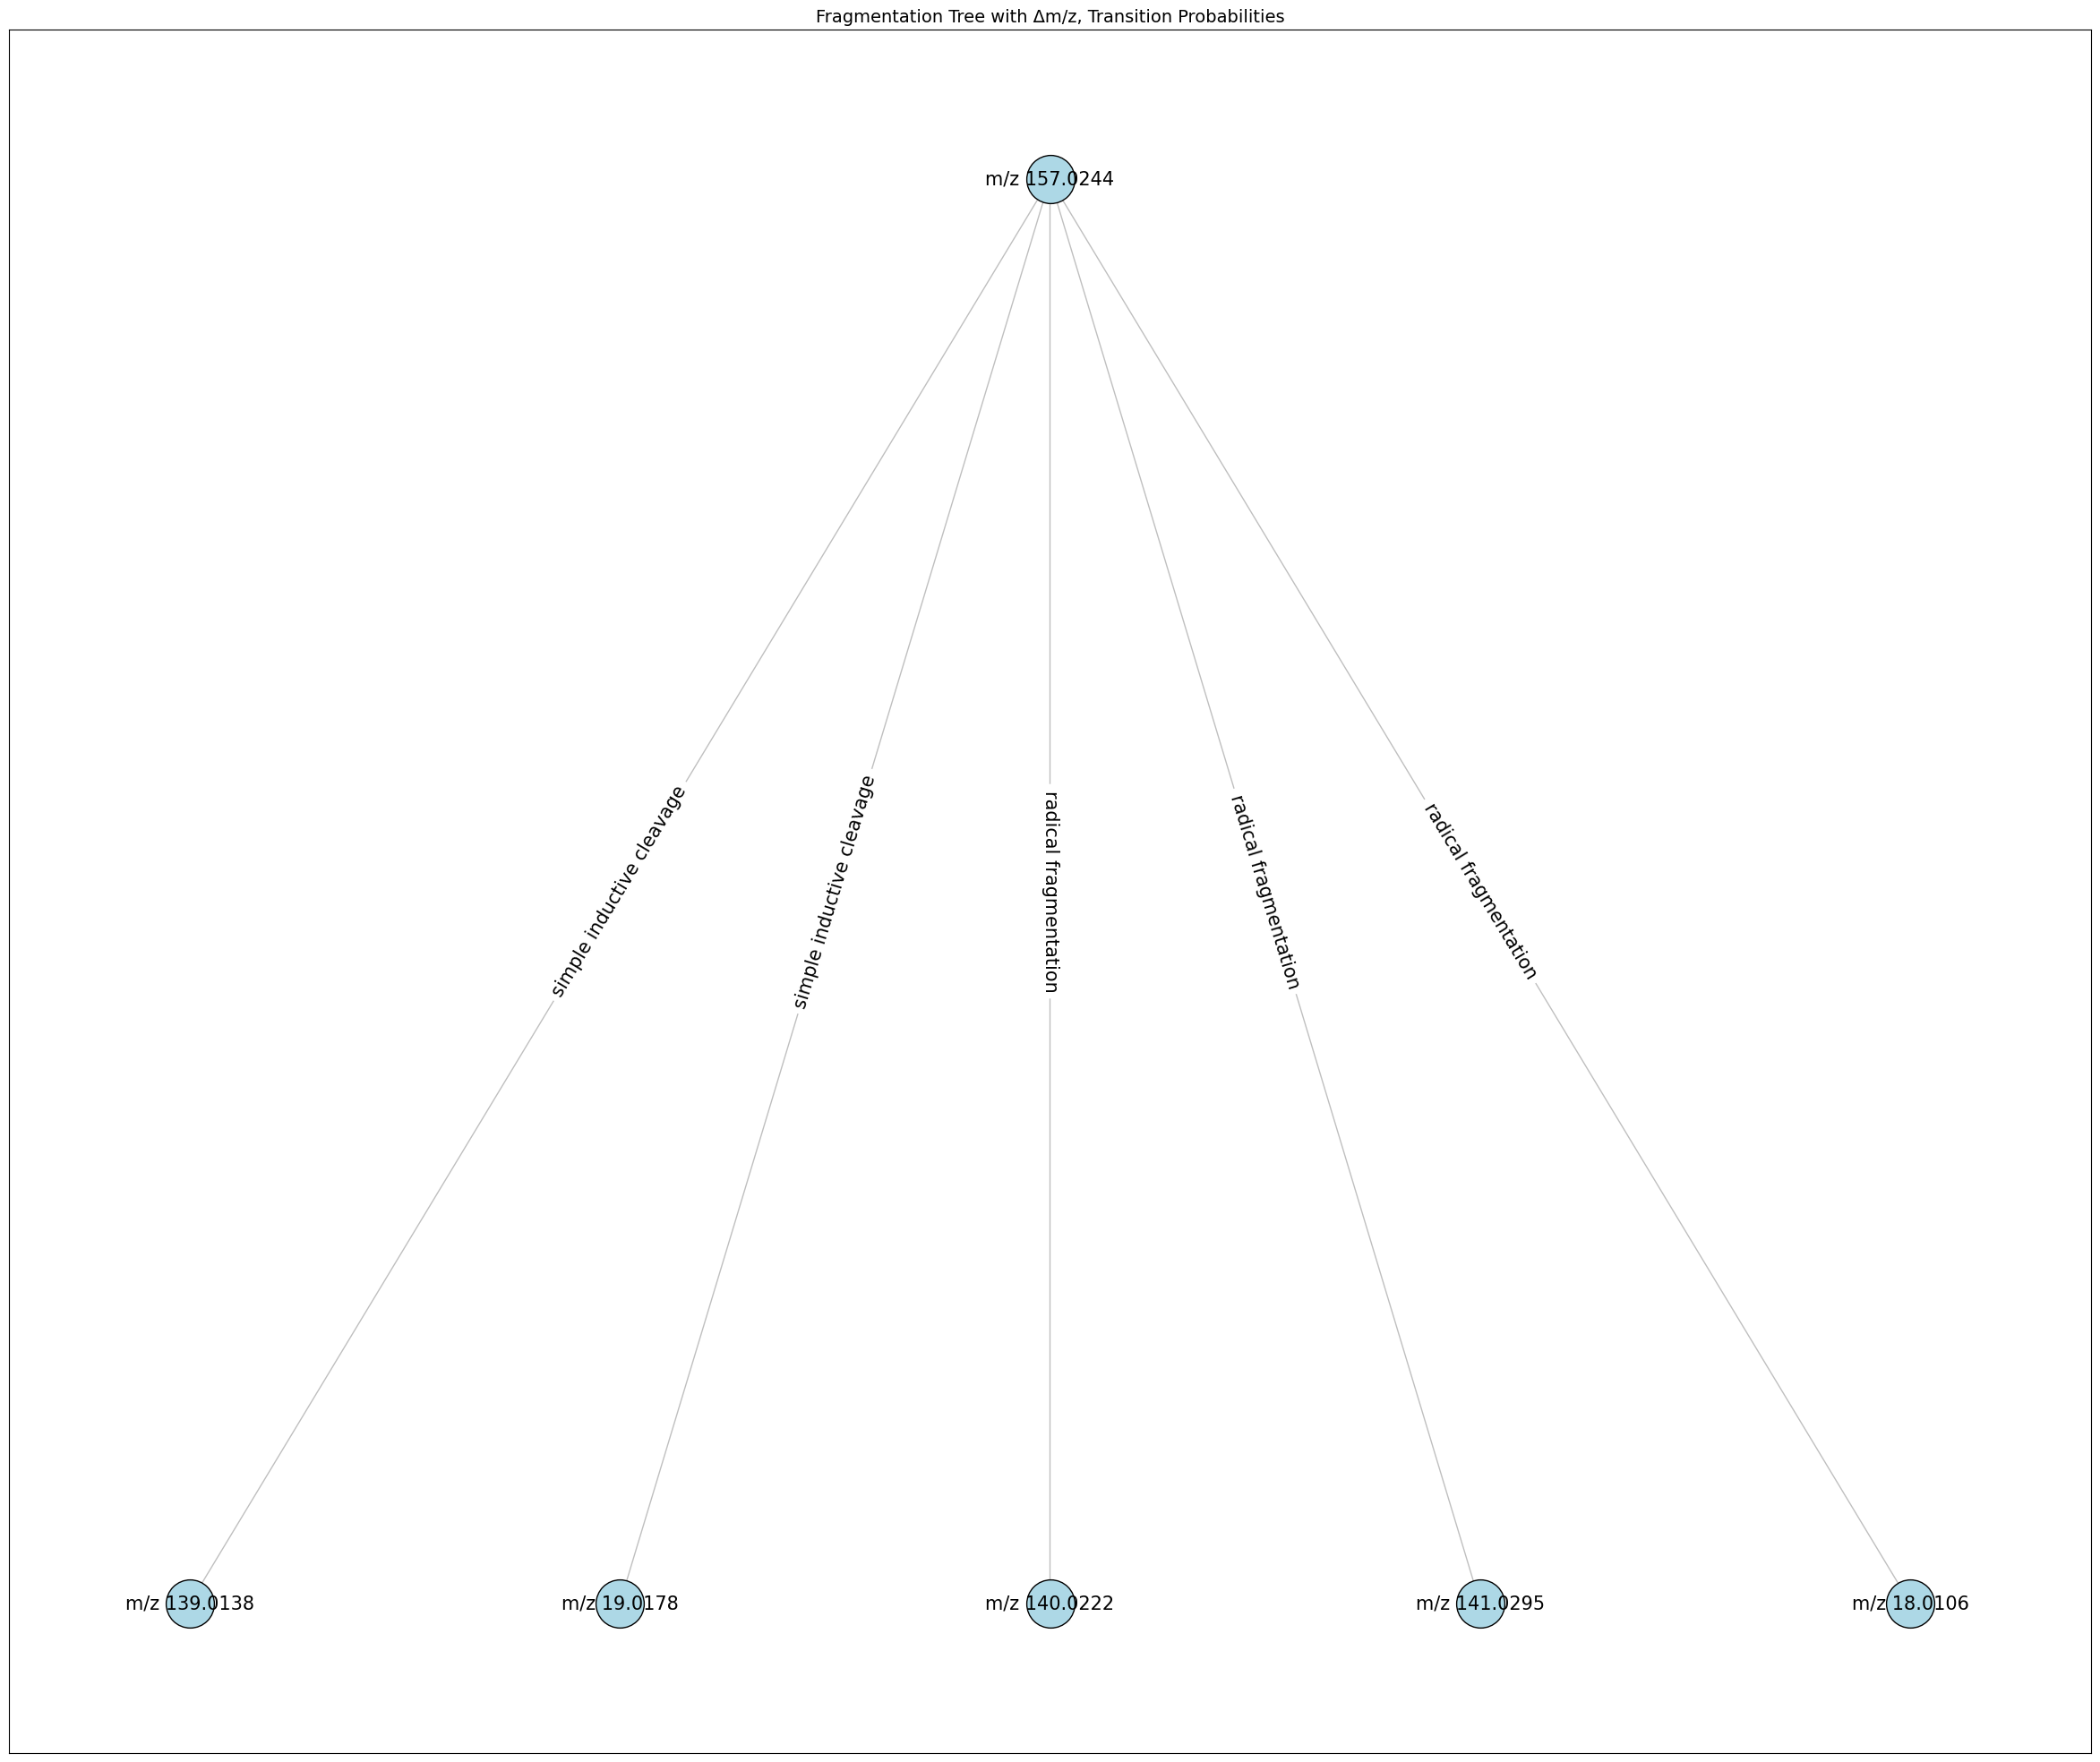

In [190]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_fragmentation_tree(peaks_df, fragmentation_tree, transition_probabilities):
    """
    Plots a fragmentation tree with Δm/z values, reaction labels, and hierarchical layout.
    """

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges based on fragmentation_tree
    node_labels = {}
    node_mz_map = {}  # Mapping node index to its m/z value

    for parent_mass, child_mass, reaction in fragmentation_tree:
        # Find indices of parent and child nodes based on their m/z values
        parent_node = peaks_df[peaks_df['mz'].apply(lambda x: abs(x - parent_mass) < 0.01)].index[0]
        child_node = peaks_df[peaks_df['mz'].apply(lambda x: abs(x - child_mass) < 0.01)].index[0]

        # Add nodes and labels
        if parent_node not in G:
            G.add_node(parent_node)
            node_labels[parent_node] = f"m/z {parent_mass:.4f}"
            node_mz_map[parent_node] = parent_mass

        if child_node not in G:
            G.add_node(child_node)
            node_labels[child_node] = f"m/z {child_mass:.4f}"
            node_mz_map[child_node] = child_mass

        # Add directed edge with reaction label
        G.add_edge(parent_node, child_node, reaction=reaction)

    # Identify the precursor node (largest m/z value)
    precursor_node = peaks_df['mz'].idxmax()

    # Compute node depths (distance from precursor ion)
    if precursor_node in G:
        node_depths = nx.single_source_shortest_path_length(G, precursor_node)
    else:
        print(f" Warning: Precursor node {precursor_node} is not in the graph.")
        node_depths = {node: 0 for node in G.nodes()}  # Default all nodes to level 0

    # Ensure all nodes are in node_depths
    for node in G.nodes():
        if node not in node_depths:
            node_depths[node] = max(node_depths.values(), default=0) + 1  # Place at lowest level

    # Group nodes by depth (tree levels)
    levels = defaultdict(list)
    for node, depth in node_depths.items():
        levels[depth].append(node)

    # Custom layout for the tree structure
    pos = {}
    horizontal_spacing = 2.0  # Spacing between nodes at the same level
    vertical_spacing = 1.5    # Spacing between levels

    for depth, nodes in levels.items():
        num_nodes = len(nodes)
        for i, node in enumerate(nodes):
            pos[node] = (i * horizontal_spacing - num_nodes * horizontal_spacing / 2, -depth * vertical_spacing)

    # Ensure all nodes have positions
    for node in G.nodes():
        if node not in pos:
            pos[node] = (0, 0)  # Assign a default position

    # Add m/z differences and transition probabilities as edge labels
    edge_labels = {}
    for (parent, child), (n, m, loss_name) in zip(G.edges(), fragmentation_tree):
        parent_mass = node_mz_map[parent]
        child_mass = node_mz_map[child]
        mz_diff = abs(parent_mass - child_mass)

        # Retrieve transition probability using correct indexing
        transition_prob = transition_probabilities.get((parent_mass, child_mass), 0)
        
        print(f"Transition prob for ({parent_mass}, {child_mass}): {transition_prob}")

        # Format the label with Δm/z and transition probability
        edge_labels[(parent, child)] = loss_name.replace('_', ' ')

    # Draw the updated graph
    plt.figure(figsize=(30, 25))

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='lightblue', edgecolors="black")

    # Draw the edges
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=15, edge_color='gray', alpha=0.5)

    # Draw the node labels (m/z values)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=15, font_color='black')

    # Draw the edge labels (reaction name, Δm/z, and transition probability)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15)

    # Set plot title
    plt.title("Fragmentation Tree with Δm/z, Transition Probabilities", fontsize=14)

    # Show the plot
    plt.show()

plot_fragmentation_tree(peaks_df, fragmentation_tree, transition_probabilities)


Transition prob for (157.02438306009, 139.01381837609): 0.6403217843319634
Transition prob for (157.02438306009, 19.01784113609): 0.5487420141396298
Transition prob for (157.02438306009, 140.022191988): 0.5536070333380204
Transition prob for (157.02438306009, 141.02946844009): 0
Transition prob for (157.02438306009, 18.010564684): 0.6285347397778812


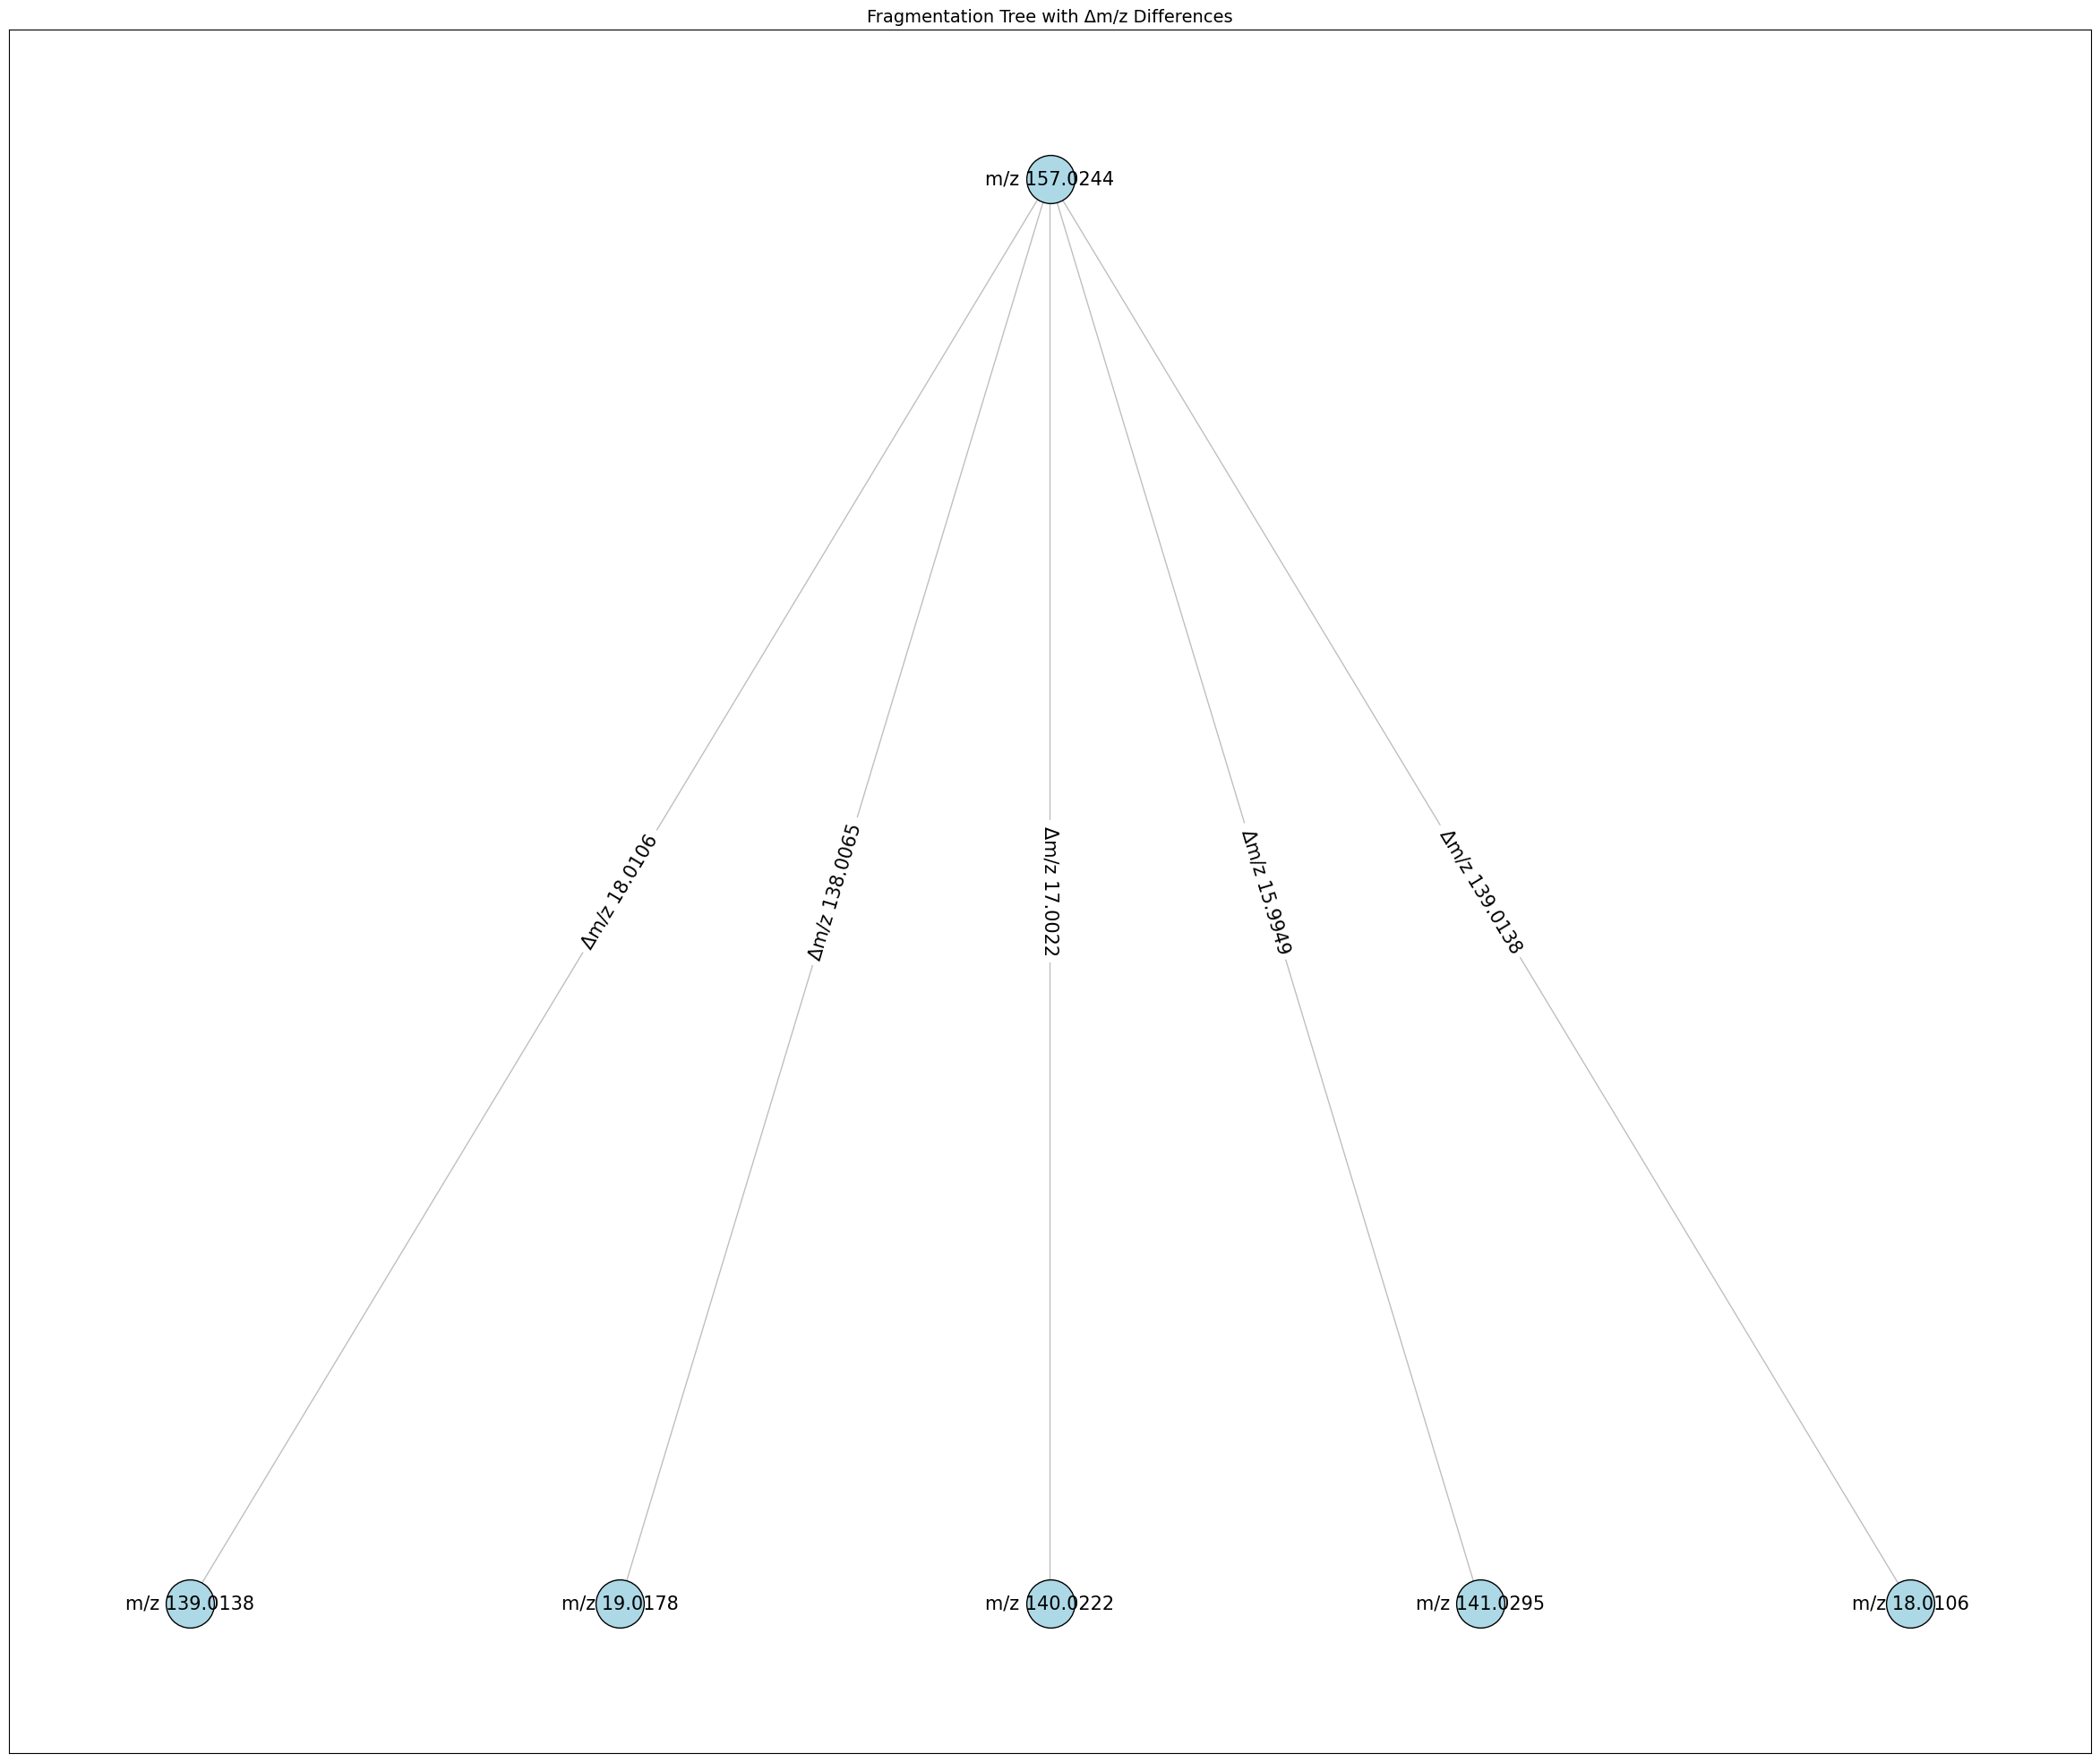

In [191]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_fragmentation_tree(peaks_df, fragmentation_tree, transition_probabilities):
    """
    Plots a fragmentation tree with Δm/z values and hierarchical layout.
    """

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges based on fragmentation_tree
    node_labels = {}
    node_mz_map = {}  # Mapping node index to its m/z value

    for parent_mass, child_mass, reaction in fragmentation_tree:
        # Find indices of parent and child nodes based on their m/z values
        parent_node = peaks_df[peaks_df['mz'].apply(lambda x: abs(x - parent_mass) < 0.01)].index[0]
        child_node = peaks_df[peaks_df['mz'].apply(lambda x: abs(x - child_mass) < 0.01)].index[0]

        # Add nodes and labels
        if parent_node not in G:
            G.add_node(parent_node)
            node_labels[parent_node] = f"m/z {parent_mass:.4f}"
            node_mz_map[parent_node] = parent_mass

        if child_node not in G:
            G.add_node(child_node)
            node_labels[child_node] = f"m/z {child_mass:.4f}"
            node_mz_map[child_node] = child_mass

        # Add directed edge with reaction label
        G.add_edge(parent_node, child_node, reaction=reaction)

    # Identify the precursor node (largest m/z value)
    precursor_node = peaks_df['mz'].idxmax()

    # Compute node depths (distance from precursor ion)
    if precursor_node in G:
        node_depths = nx.single_source_shortest_path_length(G, precursor_node)
    else:
        print(f" Warning: Precursor node {precursor_node} is not in the graph.")
        node_depths = {node: 0 for node in G.nodes()}  # Default all nodes to level 0

    # Ensure all nodes are in node_depths
    for node in G.nodes():
        if node not in node_depths:
            node_depths[node] = max(node_depths.values(), default=0) + 1  # Place at lowest level

    # Group nodes by depth (tree levels)
    levels = defaultdict(list)
    for node, depth in node_depths.items():
        levels[depth].append(node)

    # Custom layout for the tree structure
    pos = {}
    horizontal_spacing = 2.0  # Spacing between nodes at the same level
    vertical_spacing = 1.5    # Spacing between levels

    for depth, nodes in levels.items():
        num_nodes = len(nodes)
        for i, node in enumerate(nodes):
            pos[node] = (i * horizontal_spacing - num_nodes * horizontal_spacing / 2, -depth * vertical_spacing)

    # Ensure all nodes have positions
    for node in G.nodes():
        if node not in pos:
            pos[node] = (0, 0)  # Assign a default position

    # Add m/z differences as edge labels instead of loss names
    edge_labels = {}
    for (parent, child), (n, m, loss_name) in zip(G.edges(), fragmentation_tree):
        parent_mass = node_mz_map[parent]
        child_mass = node_mz_map[child]
        mz_diff = abs(parent_mass - child_mass)

        # Retrieve transition probability using correct indexing (if needed)
        transition_prob = transition_probabilities.get((parent_mass, child_mass), 0)
        print(f"Transition prob for ({parent_mass}, {child_mass}): {transition_prob}")

        # Use m/z difference for the edge label
        edge_labels[(parent, child)] = f"Δm/z {mz_diff:.4f}"

    # Draw the updated graph
    plt.figure(figsize=(30, 25))

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='lightblue', edgecolors="black")

    # Draw the edges
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=15, edge_color='gray', alpha=0.5)

    # Draw the node labels (m/z values)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=15, font_color='black')

    # Draw the edge labels (m/z differences)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15)

    # Set plot title
    plt.title("Fragmentation Tree with Δm/z Differences", fontsize=14)

    # Show the plot
    plt.show()

plot_fragmentation_tree(peaks_df, fragmentation_tree, transition_probabilities)


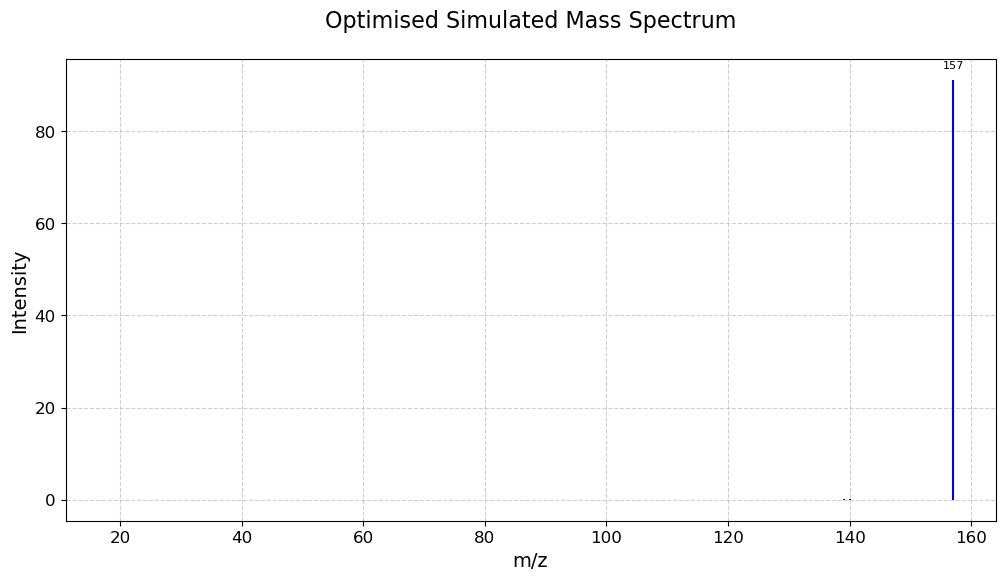

           mz intensity  observed_intensity
0  157.024383         1           91.134208
1  139.013818         1            0.072471
2   19.017841         1            0.000000
3  140.022192         1            0.168815
4  141.029468         1            0.000000
5   18.010565         1            0.000000


In [193]:
import matplotlib.pyplot as plt

def plot_mass_spectrum(peaks_df):
    """
    Plots a mass spectrum using the optimised intensities from peaks_df and annotates peaks 
    with an intensity above 10 with their corresponding m/z value.
    """
    # Extract m/z values and their corresponding optimized intensities
    mz_values = peaks_df["mz"].values
    optimized_intensities = peaks_df["observed_intensity"].values  # GA-optimized intensities

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.vlines(mz_values, ymin=0, ymax=optimized_intensities, color='blue', 
               linewidth=1.5, label="Optimised Intensities")

    # Annotate peaks where intensity > 10 with the m/z value
    for mz, intensity in zip(mz_values, optimized_intensities):
        if intensity > 10:
            plt.annotate(f"{int(mz)}", 
                         xy=(mz, intensity), 
                         xytext=(mz, intensity + 2),  # Position annotation just above the peak
                         fontsize=8, ha="center", va="bottom", color="black")

    # Add labels and title
    plt.xlabel("m/z", fontsize=14)
    plt.ylabel("Intensity", fontsize=14)
    plt.title("Optimised Simulated Mass Spectrum", fontsize=16, y = 1.05)

    # Customize tick font sizes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Show grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Show the plot
    plt.show()

# Call the function to plot the spectrum
plot_mass_spectrum(peaks_df)
print(peaks_df)


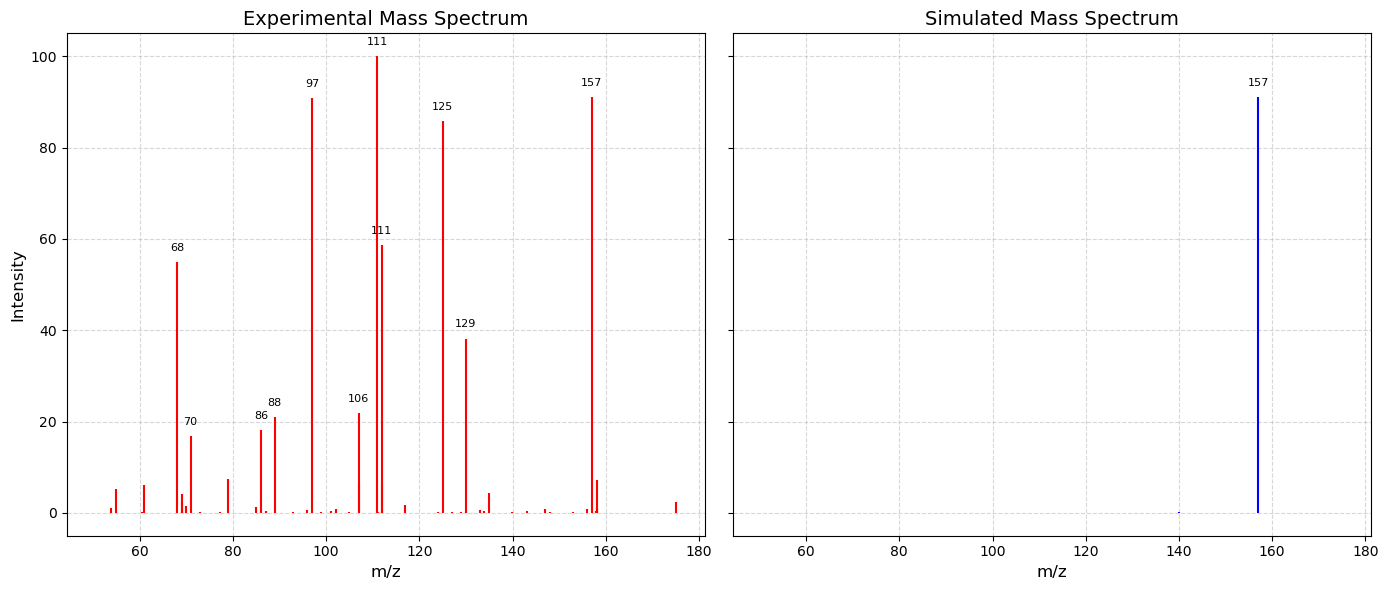

In [194]:
import matplotlib.pyplot as plt

def plot_comparison_spectra(peaks_df, spectra_df):
    """
    Plots the actual (experimental) mass spectrum from spectra_df and 
    the optimised mass spectrum from peaks_df side by side, ensuring 
    that the simulated spectrum uses the same x-axis scale as the experimental spectrum.
    """

    # Extract Experimental (Actual) Data
    exp_mz_values = spectra_df["m/z"].values
    exp_intensities = spectra_df["normalised_intensity"].values  # Experimental intensities

    # Extract Optimized (GA) Data
    opt_mz_values = peaks_df["mz"].values
    opt_intensities = peaks_df["observed_intensity"].values  # Optimized intensities from GA

    # Create a figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # --- Plot Experimental Spectrum ---
    axes[0].vlines(exp_mz_values, ymin=0, ymax=exp_intensities, color='red', linewidth=1.5)
    axes[0].set_xlabel("m/z", fontsize=12)
    axes[0].set_ylabel("Intensity", fontsize=12)
    axes[0].set_title("Experimental Mass Spectrum", fontsize=14)
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # Annotate peaks with intensity > 10
    for mz, intensity in zip(exp_mz_values, exp_intensities):
        if intensity > 10:
            axes[0].annotate(
                f"{int(mz)}", 
                (mz, intensity + 2),  # Position above peak
                fontsize=8, ha="center", va="bottom", color="black"
            )

    # --- Plot Optimized Spectrum ---
    axes[1].vlines(opt_mz_values, ymin=0, ymax=opt_intensities, color='blue', linewidth=1.5)
    axes[1].set_xlabel("m/z", fontsize=12)
    axes[1].set_title("Simulated Mass Spectrum", fontsize=14)
    axes[1].grid(True, linestyle='--', alpha=0.5)

    # Annotate peaks with intensity > 10
    for mz, intensity in zip(opt_mz_values, opt_intensities):
        if intensity > 10:
            axes[1].annotate(
                f"{int(mz)}", 
                (mz, intensity + 2),  # Position above peak
                fontsize=8, ha="center", va="bottom", color="black"
            )
            
    # Set the x-axis limits for the simulated spectrum to match the experimental spectrum
    axes[1].set_xlim(axes[0].get_xlim())

    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function to plot both spectra
plot_comparison_spectra(peaks_df, spectra_df)



In [204]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Function to normalize spectrum to max intensity of 1
def normalize_spectrum(spectrum):
    spectrum = spectrum.copy()  # Avoid modifying the original DataFrame
    max_intensity = spectrum['observed_intensity'].max()
    if max_intensity > 0:
        spectrum['observed_intensity'] /= max_intensity
    return spectrum

# Function to calculate intensities for each fragment node based on the tree and transition probabilities
def calculate_intensities_from_tree(tree_edges, precursor_intensity, transition_probs):
    intensities = {tree_edges[0][0]: precursor_intensity}  # Initialize with precursor node intensity
    for (u, v) in tree_edges:
        if u in intensities:  # If precursor intensity is known
            intensities[v] = intensities[u] * transition_probs.get((u, v), 0)
    return intensities

# Function to back-calculate the spectrum from the tree and transition probabilities
def back_calculate_spectrum_from_tree(tree_nodes, tree_edges, peaks_df, transition_probs):
    precursor_intensity = peaks_df.loc[tree_nodes[0], 'observed_intensity']  # Precursor's intensity
    calculated_intensities = calculate_intensities_from_tree(tree_edges, precursor_intensity, transition_probs)
    
    back_calculated_spectrum = peaks_df.loc[tree_nodes][['mz']].copy()
    back_calculated_spectrum['observed_intensity'] = back_calculated_spectrum.index.map(lambda x: calculated_intensities.get(x, 0))
    
    # Normalize the back-calculated spectrum
    back_calculated_spectrum = normalize_spectrum(back_calculated_spectrum)
    
    return back_calculated_spectrum

# Align the m/z values of the original and back-calculated spectra
def align_spectra(original_spectrum, calculated_spectrum):
    merged_spectrum = pd.merge(original_spectrum, calculated_spectrum, on='mz', how='outer', 
                               suffixes=('_orig', '_calc')).fillna(0)
    return merged_spectrum

# Calculate cosine similarity between original and back-calculated spectra by focusing on nonzero values
def calculate_cosine_similarity(merged_spectrum):
    # Get the intensity arrays from the merged spectrum (using the correct column names)
    orig = merged_spectrum['observed_intensity_orig'].values
    calc = merged_spectrum['observed_intensity_calc'].values
    
    # Mask: select only rows where at least one intensity is nonzero.
    mask = (orig != 0) | (calc != 0)
    if np.sum(mask) == 0:
        return 0  # If there's no nonzero data, similarity is 0.
        
    orig_nonzero = orig[mask].reshape(1, -1)
    calc_nonzero = calc[mask].reshape(1, -1)
    
    similarity = cosine_similarity(orig_nonzero, calc_nonzero)[0, 0]
    return similarity

# Extract unique nodes from edges
def calculate_nodes_from_edges(edges):
    nodes = set()
    for u, v in edges:
        nodes.add(u)
        nodes.add(v)
    return list(nodes)

# Example data (Ensure edges and transition probabilities are defined)
edges = [(0, 1), (1, 2), (1, 3)]  # Example edges
transition_probabilities = {(0, 1): 0.8, (1, 2): 0.5, (1, 3): 0.7}  # Example transition probabilities

# Example usage to calculate cosine similarity
selected_nodes = calculate_nodes_from_edges(edges)  # Nodes selected by ILP in the fragmentation tree

# Prepare the original spectrum DataFrame.
original_spectrum = peaks_df[['mz', 'observed_intensity']].copy()
original_spectrum = normalize_spectrum(original_spectrum)
print("\nOriginal spectrum (normalized):\n", original_spectrum)

back_calculated_spectrum = back_calculate_spectrum_from_tree(selected_nodes, edges, peaks_df, transition_probabilities)
print("\nBack-calculated spectrum (normalized):\n", back_calculated_spectrum)

merged_spectrum = align_spectra(original_spectrum, back_calculated_spectrum)
cosine_sim = calculate_cosine_similarity(merged_spectrum)
print(f"Cosine Similarity between original and back-calculated spectra (normalized): {cosine_sim:.4f}")


KeyError: "['observed_intensity'] not in index"